In [1]:
import swyft
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
class Gaussian(swyft.Simulator):
    def __init__(self, nbins=100, nparams=2, sigma=0.1, bounds=None):
        super().__init__()
        self.x = np.linspace(-1, 1, nbins)
        self.nbins = nbins
        self.nparams = nparams
        self.sigma = 0.1
        self.transform_samples = swyft.to_numpy32
    
    def get_params(self):
        bounds = np.array([[-1, 1], [-1, 1]])
        return np.array([np.random.uniform(bounds[0, 0], bounds[0, 1]), np.random.uniform(bounds[1, 0], bounds[1, 1])])
    
    def get_data(self, params):
        trend_line = params[0] * self.x + params[1]
        return trend_line + np.random.normal(0, self.sigma, self.nbins)
    
    def build(self, graph):
        z = graph.node('z', self.get_params)
        x = graph.node('x', self.get_data, z)


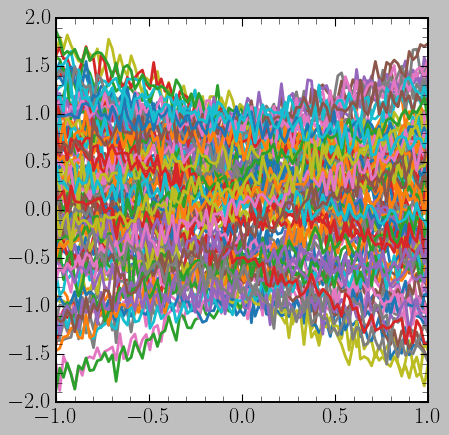

In [45]:
sim = Gaussian(100, 2, sigma=0.2)
for i in range(100):
    plt.plot(sim.x, sim.sample()['x'])

In [41]:
database = sim.sample(10000)



100%|██████████| 10000/10000 [00:00<00:00, 76960.27it/s]


In [50]:
means = np.mean(sim.sample(1000, conditions={'z': np.array([0.1, 0.1])})['x'], axis=0)


100%|██████████| 1000/1000 [00:00<00:00, 77716.91it/s]


Epoch 6:   1%|          | 1/157 [05:19<13:51:57, 319.99s/it, loss=-3.63, v_num=40, val_loss=-3.60]


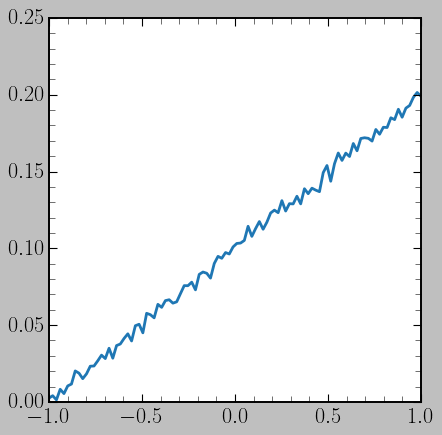

In [51]:
plt.plot(sim.x, means, label='mean')

In [109]:
from typing import Any
from swyft.networks import OnlineStandardizingLayer

class InferenceNetwork(swyft.SwyftModule, swyft.AdamWReduceLROnPlateau):
    def __init__(self, est_means, sim):
        super().__init__()
        self.means = est_means
        self.sim = sim
        self.learning_rate = 1e-3
        self.fc1 = nn.Linear(sim.nbins, sim.nparams)
        self.lrs1d = swyft.LogRatioEstimator_1dim(sim.nparams, num_params=sim.nparams, varnames='z')
        self.lrs2d = swyft.LogRatioEstimator_Ndim(sim.nparams, marginals = ((0, 1),), varnames='z')
        self.nl1 = OnlineStandardizingLayer(shape=(sim.nbins,))
        self.mean_layer = nn.Sequential(nn.Linear(sim.nbins, 10),
                                        nn.Linear(10, sim.nbins))
    
    def forward(self, A, B):
        mu = self.mean_layer(self.nl1(A['x'])).detach() # d_theta mu * (x - mu)
        diff = self.nl1(A['x']) - mu
        score_compression = self.fc1(self.nl1(diff))
        #score_compression = self.fc1(A['x'])
        lrs1d = self.lrs1d(score_compression, B['z'])
        lrs2d = self.lrs2d(score_compression, B['z'])
        return lrs1d, lrs2d

In [110]:
trainer = swyft.SwyftTrainer(accelerator='cpu')
dm = swyft.SwyftDataModule(database, batch_size=64)
network = InferenceNetwork(means, sim)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [111]:
trainer.fit(network, dm)

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                     | Params
--------------------------------------------------------
0 | fc1        | Linear                   | 202   
1 | lrs1d      | LogRatioEstimator_1dim   | 34.9 K
2 | lrs2d      | LogRatioEstimator_Ndim   | 17.5 K
3 | nl1        | OnlineStandardizingLayer | 0     
4 | mean_layer | Sequential               | 2.1 K 
--------------------------------------------------------
54.8 K    Trainable params
0         Non-trainable params
54.8 K    Total params
0.219     Total estimated model params size (MB)


/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 11: 100%|██████████| 157/157 [00:03<00:00, 40.54it/s, loss=-2.42, v_num=57, val_loss=-2.31]
Reloading best model: /Users/james/Code/Scrapbook/swyft-test/lightning_logs/version_57/checkpoints/epoch=6-step=875.ckpt


In [112]:
observation = sim.sample(conditions={'z': np.array([0.1, 0.1])})
prior_samples = sim.sample(targets = ['z'], N = 100000)

100%|██████████| 100000/100000 [00:00<00:00, 137183.62it/s]


In [113]:
predictions = trainer.infer(network, observation, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 98/98 [00:03<00:00, 27.41it/s]


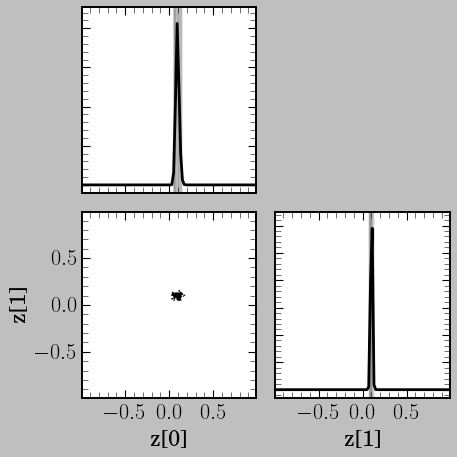

In [114]:
swyft.plot_corner(predictions, parnames = ['z[0]', 'z[1]']);

In [216]:
new_bounds = swyft.collect_rect_bounds(predictions[0], 'z', (2,), threshold = 1e-6)
new_bounds

tensor([[0.5000, 0.8748],
        [1.0000, 2.9999]])

In [56]:
sim = Gaussian(100, 2, new_bounds)

In [57]:
database = sim.sample(100000)

100%|██████████| 100000/100000 [00:02<00:00, 33830.81it/s]


In [58]:
means = np.mean(database['x'], axis=0)
network = InferenceNetwork(means, sim)
trainer = swyft.SwyftTrainer(accelerator='cpu')
dm = swyft.SwyftDataModule(database, batch_size=64)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [59]:
trainer.fit(network, dm)

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name  | Type                   | Params
-------------------------------------------------
0 | fc1   | Linear                 | 202   
1 | lrs1d | LogRatioEstimator_1dim | 34.9 K
2 | lrs2d | LogRatioEstimator_Ndim | 17.5 K
-------------------------------------------------
52.7 K    Trainable params
0         Non-trainable params
52.7 K    Total params
0.211     Total estimated model params size (MB)


/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 10:  13%|█▎        | 201/1563 [00:05<00:34, 38.99it/s, loss=-3.3, v_num=5, val_loss=-3.30] 

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [60]:
predictions = trainer.infer(network, observation, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 98/98 [00:03<00:00, 31.93it/s]


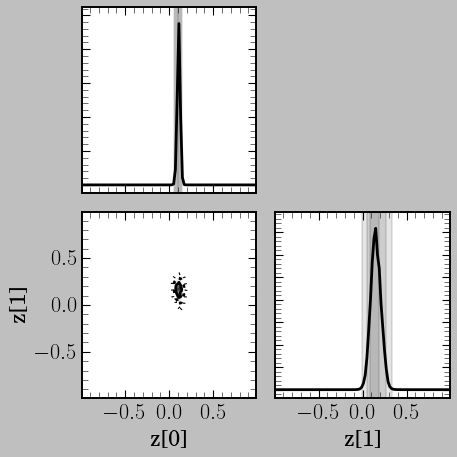

In [61]:
swyft.plot_corner(predictions, parnames = ['z[0]', 'z[1]']);

In [66]:
bounds = torch.tensor([[-0.3, 0.3], [-0.3, 0.3]])
sim = Gaussian(100, 2, bounds)
database = sim.sample(100000)
means = np.mean(database['x'], axis=0)
network = InferenceNetwork(means, sim)
trainer = swyft.SwyftTrainer(accelerator='cpu')
dm = swyft.SwyftDataModule(database, batch_size=64)
trainer.fit(network, dm)


100%|██████████| 100000/100000 [00:02<00:00, 34683.35it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name  | Type                   | Params
-------------------------------------------------
0 | fc1   | Linear                 | 202   
1

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24:   8%|▊         | 119/1563 [00:03<00:36, 39.41it/s, loss=-2.86, v_num=8, val_loss=-2.76] 

/Users/james/Code/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


100%|██████████| 100000/100000 [00:00<00:00, 253306.45it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Epoch 2:  30%|██▉       | 466/1563 [06:25<15:07,  1.21it/s, loss=-2.68, v_num=10, val_loss=-2.69]


(-0.3, 0.3)

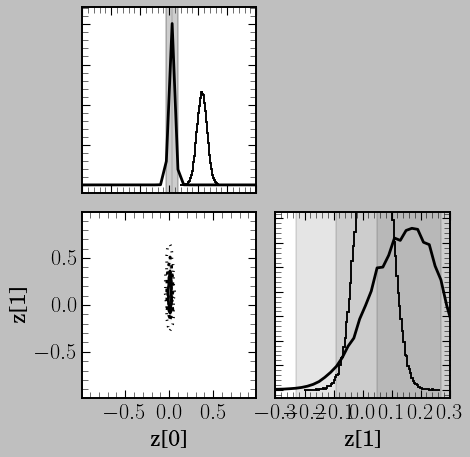

In [123]:
predictions = trainer.infer(network, observation, sim.sample(targets = ['z'], N = 100000))
swyft.plot_corner(predictions, parnames = ['z[0]', 'z[1]']);
ax = plt.subplot(2, 2, 1)
plt.hist(samples[:, 0], 100, color="k", histtype="step", density=True);
plt.xlim(-0.3, 0.3)
ax = plt.subplot(2, 2, 4)
plt.hist(samples[:, 1], 100, color="k", histtype="step", density=True);
plt.xlim(-0.3, 0.3)

In [75]:
def score(sample):
    trend_line = sim.x * sample['z'][0] + sample['z'][1]
    return np.array([1./0.5**2 * np.dot((sample['x'] - trend_line), sim.x), 1./0.5**2 * np.dot((sample['x'] - trend_line), np.ones_like(sim.x))])

In [192]:
collect_net_samples = []
collect_score_samples = []
import tqdm
network.eval()
with torch.no_grad():
    network.eval()
    for i in tqdm.tqdm(range(1000)):
        sample = sim.sample()
        out = network.fc1(network.normalising_layer((1/0.5**2) * (torch.tensor(sample['x'] - means[None, :]))))
        collect_net_samples.append(out[0].numpy())
        collect_score_samples.append(score(sample))

100%|██████████| 1000/1000 [00:00<00:00, 11988.69it/s]


In [193]:
net_samples = np.vstack(collect_net_samples)
score_sample = np.vstack(collect_score_samples)

(array([ 1.,  0.,  1.,  0.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  0.,
         0.,  2.,  1.,  1.,  0.,  2.,  0.,  5.,  7.,  3.,  1.,  4.,  4.,
         5.,  5.,  6.,  7., 12.,  8.,  8., 14., 13., 22., 16., 29., 18.,
        23., 19., 35., 39., 40., 30., 36., 37., 46., 50., 34., 41., 49.,
        40., 28., 30., 23., 18., 26., 14., 20.,  9., 13.,  9.,  9., 12.,
         7.,  3.,  4.,  3.,  6.,  6.,  3.,  7.,  4.,  4.,  3.,  2.,  1.,
         0.,  2.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-3.04427558, -2.92002323, -2.79577089, -2.67151855, -2.54726621,
        -2.42301387, -2.29876152, -2.17450918, -2.05025684, -1.9260045 ,
        -1.80175216, -1.67749981, -1.55324747, -1.42899513, -1.30474279,
        -1.18049045, -1.0562381 , -0.93198576, -0.80773342, -0.68348108,
        -0.55922874, -0.43497639, -0.31072405, -0.18647171, -0.06221937,
         0.06203297,  0.18628532,  0.31053766,  0.43479   ,  0.559042

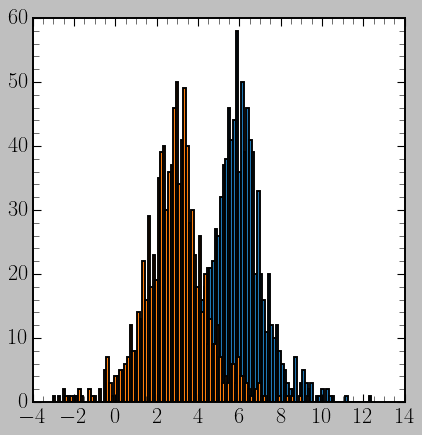

In [194]:
plt.hist(np.log(np.abs(score_sample[:, 0] / net_samples[:, 0])), bins=100)
plt.hist(np.log(np.abs(score_sample[:, 1] / net_samples[:, 1])), bins=100)

In [98]:
net_samples = np.vstack(collect_net_samples)
score_sample = np.vstack(collect_score_samples)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  2.,  2.,  0.,  0.,
         3.,  3.,  2.,  1.,  2.,  1.,  2.,  3.,  4.,  2.,  4.,  5., 14.,
         7., 12., 17., 10., 16., 16.,  9., 24., 17., 15., 23., 38., 33.,
        42., 48., 28., 38., 38., 45., 44., 40., 41., 32., 40., 42., 21.,
        32., 24., 13., 16., 10., 15.,  8., 13.,  9., 11., 10.,  5.,  6.,
         3.,  2.,  1.,  4.,  4.,  1.,  2.,  3.,  2.,  3.,  3.,  1.,  1.,
         2.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([-7.01903644, -6.89197182, -6.7649072 , -6.63784258, -6.51077796,
        -6.38371334, -6.25664872, -6.1295841 , -6.00251948, -5.87545486,
        -5.74839024, -5.62132562, -5.494261  , -5.36719638, -5.24013176,
        -5.11306714, -4.98600252, -4.8589379 , -4.73187328, -4.60480866,
        -4.47774404, -4.35067942, -4.2236148 , -4.09655018, -3.96948556,
        -3.84242094, -3.71535632, -3.5882917 , -3.46122708, -3.334162

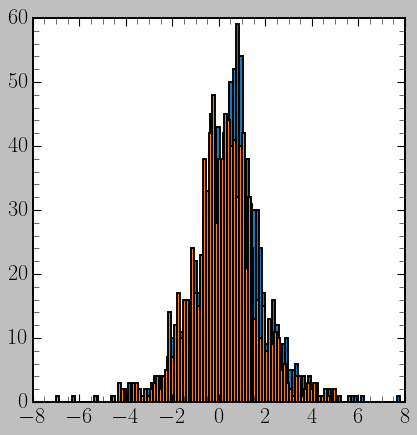

In [99]:
plt.hist(np.log(np.abs(score_sample[:, 0] / net_samples[:, 0])), bins=100)
plt.hist(np.log(np.abs(score_sample[:, 1] / net_samples[:, 1])), bins=100)

In [107]:
def log_prob(theta, x):
    mu = theta[0] * sim.x + theta[1]
    diff = x - mu
    return -(1/(2 * 0.5**2)) * np.dot(diff, diff)

ndim = 2
nwalkers = 32
p0 = -2 * np.random.rand(nwalkers, ndim) + 1
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[observation['x']])
state = sampler.run_mcmc(p0, 100)
sampler.reset()
sampler.run_mcmc(state, 10000);


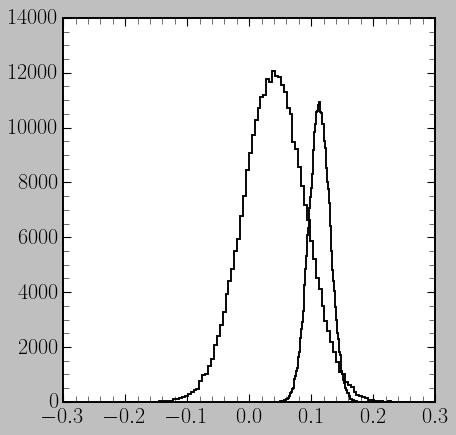

In [108]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step");
plt.hist(samples[:, 1], 100, color="k", histtype="step");